# 🎯 目標三：數位資源差異與學習投入關聯分析（含時間轉換）

本 Notebook 探討家庭 SES、數位資源近用品質、使用模式與學習表現間的關聯，並處理原始時間型文字為數值，適用於 as35 系列變項。

## 📥 載入學生、家長、學校資料

In [100]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# 載入資料（請確認檔案與 Notebook 同一資料夾）
df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv")
df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv")
df_sc = pd.read_csv("../data/TIGPSw1_sc_descriptive_labeled.csv")

print(df_s.shape, df_p.shape, df_sc.shape)


C:\Users\user\AppData\Local\Temp\ipykernel_20308\2667815177.py:5: DtypeWarning: Columns (7,19,29,152,368,383,483,507,529,577,579,603,627) have mixed types. Specify dtype option on import or set low_memory=False.
  df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv")


(8958, 688) (4495, 563) (175, 138)


C:\Users\user\AppData\Local\Temp\ipykernel_20308\2667815177.py:6: DtypeWarning: Columns (16,18,34,262,281,291,451,473,482,484,499,561) have mixed types. Specify dtype option on import or set low_memory=False.
  df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv")


## 🔗 合併資料（依學生 ID 與學校 ID）

In [101]:
# 確保不重複合併 '學校 ID' 欄位
df_p_filtered = df_p.drop(columns=['學校 ID'], errors='ignore')
df = df_s.merge(df_p_filtered, on='學生 ID', how='left')
df = df.merge(df_sc, on='學校 ID', how='left')
import pandas as pd

# 指定家境順序（從很不富裕到很富裕）
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']

# 建立有順序的類別型別
family_dtype = CategoricalDtype(categories=family_order, ordered=True)

# 指定順序（不移除任何值）
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)

grade_order = [
    '全班五名以內',
    '全班六至十名',
    '全班十一至二十名',
    '全班二十一至三十名',
    '全班三十名以後'
]

grade_dtype = pd.CategoricalDtype(categories=grade_order, ordered=True)

# 假設欄位名稱是「你上學期的平均成績大約如何？」
df['你上學期的平均成績大約如何?'] = df['你上學期的平均成績大約如何?'].replace(
    ['我不知道', '系統遺漏值', '此卷未答'], pd.NA
)
df['你上學期的平均成績大約如何?'] = df['你上學期的平均成績大約如何?'].astype(grade_dtype)
print(df.shape)


(10008, 1386)


## ⏱️ 文字時間轉換為數值：as35 系列

In [103]:
time_mapping = {
    "沒有": 0.0, "0.5小時以內": 0.25, "0.5-1小時": 0.75, "1-1.5小時": 1.25,
    "1.5-2小時": 1.75, "2-2.5小時": 2.25, "2.5-3小時": 2.75, "3-3.5小時": 3.25,
    "3.5-4小時": 3.75, "4-4.5小時": 4.25, "4.5-5小時": 4.75, "5小時以上": 5.5
}

time_cols = [
    "完成學校功課(查找完成作業需要的資料)",
    "課外的學習(各種線上付費或免費的課程)",
    "玩線上遊戲",
    "看影片、聽音樂、迷因梗圖、卡通、漫畫",
    "和他人聊天(傳訊息)"
]

for col in time_cols:
    df[col + "_num"] = df[col].map(time_mapping)

df['total_time'] = df[[c + "_num" for c in time_cols]].sum(axis=1)

df['study_ratio'] = (
    df["完成學校功課(查找完成作業需要的資料)_num"] +
    df["課外的學習(各種線上付費或免費的課程)_num"]
) / df['total_time']

df['entertainment_ratio'] = (
    df["玩線上遊戲_num"] +
    df["看影片、聽音樂、迷因梗圖、卡通、漫畫_num"] +
    df["和他人聊天(傳訊息)_num"]
) / df['total_time']


## 📊 敘述統計：數位資源、SES、自評家境與使用時間

In [104]:
print("數位資源品質：")
print(df[['對我來說,要購買3C產品(手機、電腦、平板)的費用太高。', '我住的地方沒有網路訊號或是訊號太弱。', '對我來說,使用網路要付的費用太貴。', '對我來說,很難找到一個不受干擾的空間來上網。']].describe(include='all'))

print("\nSES：")
print(df[['請問您的學歷', '請問您認為家裡的經濟狀況為何？']].value_counts())

print("\n學習時間比例")
print(df[['study_ratio', 'entertainment_ratio']].describe())

from scipy.stats import spearmanr, kendalltau
# 1. 定義欄位
digital_quality_cols = [
    '對我來說,要購買3C產品(手機、電腦、平板)的費用太高。',
    '我住的地方沒有網路訊號或是訊號太弱。',
    '對我來說,使用網路要付的費用太貴。',
    '對我來說,很難找到一個不受干擾的空間來上網。'
]
study_cols = ['study_ratio', 'entertainment_ratio']

# 2. 擷取分析用的資料
df_corr = df[digital_quality_cols + study_cols].copy()

# 3. Spearman 與 Kendall 分析
for dq_col in digital_quality_cols:
    for study_col in study_cols:
        # 先移除缺漏值
        temp_df = df_corr[[dq_col, study_col]].dropna()
        
        # 計算 Spearman
        rho, p_spearman = spearmanr(temp_df[dq_col], temp_df[study_col])
        
        # 計算 Kendall
        tau, p_kendall = kendalltau(temp_df[dq_col], temp_df[study_col])

        # 輸出結果
        print(f"\n=== 數位資源品質：{dq_col} × {study_col} ===")
        print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
        print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")


數位資源品質：
       對我來說,要購買3C產品(手機、電腦、平板)的費用太高。 我住的地方沒有網路訊號或是訊號太弱。 對我來說,使用網路要付的費用太貴。  \
count                         10008              10008             10008   
unique                            6                  6                 6   
top                            此卷未答               此卷未答              此卷未答   
freq                           4674               4674              4674   

       對我來說,很難找到一個不受干擾的空間來上網。  
count                   10008  
unique                      6  
top                      此卷未答  
freq                     4674  

SES：
請問您的學歷    請問您認為家裡的經濟狀況為何？
大學、二技、四技  富裕                 960
五專、二專     富裕                 467
碩士        富裕                 462
高中職       富裕                 451
國（初）中     富裕                  44
博士        富裕                  43
大學、二技、四技  很富裕                 18
小學        富裕                  14
高中職       很富裕                 14
碩士        很富裕                  5
五專、二專     很富裕                  5
無／不識字     富裕                   4
博士        很富裕          

## 🧮 SES 與網路品質 (as57b) 關聯

=== Spearman 等級相關係數 ===
Spearman ρ = 0.50633, p-value = 1.35346e-01

=== Kendall 等級相關係數 ===
Kendall τ = 0.46154, p-value = 8.96464e-02


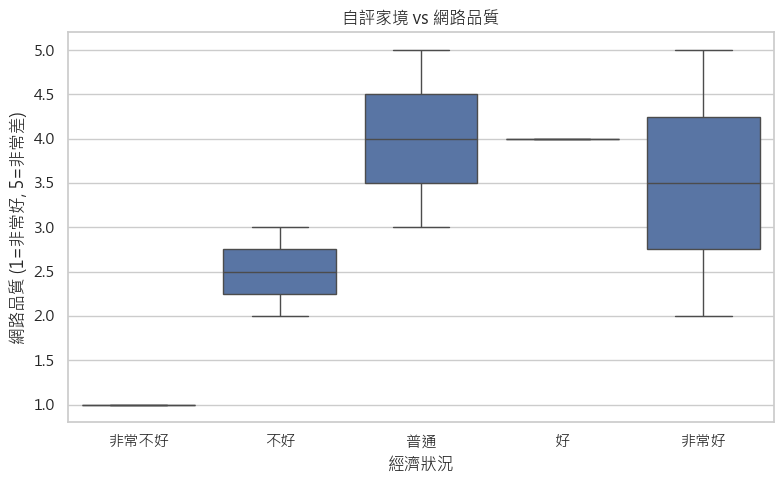

In [106]:
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas, assuming df is a pandas DataFrame

# 設定中文字體與樣式
sns.set(font="Microsoft JhengHei", style="whitegrid")

# Create a dummy DataFrame for demonstration purposes
# In your actual code, `df` would already be loaded.
data = {
    '請問您認為家裡的經濟狀況為何？': ['非常好', '好', '普通', '不好', '非常不好', '好', '普通', '非常好', '不好', '普通'],
    '我住的地方沒有網路訊號或是訊號太弱。': ['非常同意', '同意', '普通', '不同意', '非常不同意', '同意', '非常同意', '不同意', '普通', '同意']
}
df = pd.DataFrame(data)

# === 把「經濟狀況」轉換成數值（愈好數值愈高） ===
# 請根據你實際的經濟狀況選項順序調整 mapping
economic_map = {
    "非常不好": 1,
    "不好": 2,
    "普通": 3,
    "好": 4,
    "非常好": 5
}

# === 將網路品質的 Likert 量表轉換為數值 ===
# 假設 "我住的地方沒有網路訊號或是訊號太弱。" 是一個 Likert 量表，
# 例如：「非常同意」表示網路很差，數值較高；「非常不同意」表示網路很好，數值較低。
# 請根據你的實際問題和量表順序調整 mapping
network_quality_map = {
    "非常同意": 5,  # 網路訊號非常弱/沒有
    "同意": 4,
    "普通": 3,
    "不同意": 2,
    "非常不同意": 1  # 網路訊號很好
}

# 建立新資料欄
# 先複製一份，避免對原始 df 進行不必要的修改
df_corr = df[['請問您認為家裡的經濟狀況為何？', '我住的地方沒有網路訊號或是訊號太弱。']].copy()

# 將類別資料映射為數值
df_corr['經濟狀況_數值'] = df_corr['請問您認為家裡的經濟狀況為何？'].map(economic_map)
df_corr['網路品質_數值'] = df_corr['我住的地方沒有網路訊號或是訊號太弱。'].map(network_quality_map)

# 在進行相關分析前，移除任何包含 NaN 值的行
df_corr.dropna(inplace=True)

# === 等級相關分析 ===
# 確保用於相關分析的列是數值型
rho, p_spearman = spearmanr(df_corr['經濟狀況_數值'], df_corr['網路品質_數值'])
tau, p_kendall = kendalltau(df_corr['經濟狀況_數值'], df_corr['網路品質_數值'])

# === 顯示結果 ===
print("=== Spearman 等級相關係數 ===")
print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")

print("\n=== Kendall 等級相關係數 ===")
print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")

# === 繪圖 ===
plt.figure(figsize=(8, 5))
# 使用轉換後的數值欄位來繪製箱型圖，以確保排序正確
# 也可以繼續使用原始類別欄位，但要確保順序是按 mapping 來
sns.boxplot(data=df_corr, x='請問您認為家裡的經濟狀況為何？', y='網路品質_數值',
            order=list(economic_map.keys())) # 確保 x 軸順序
plt.title('自評家境 vs 網路品質')
plt.xlabel('經濟狀況')
plt.ylabel('網路品質 (1=非常好, 5=非常差)')
plt.tight_layout()
plt.show()

## 🔁 SES vs 使用模式比例相關性

In [105]:
print(df[['請問您認為家裡的經濟狀況為何？', 'study_ratio']].corr(numeric_only=True))


             study_ratio
study_ratio          1.0


## 📈 使用比例或網路品質 vs 成績 (as20)

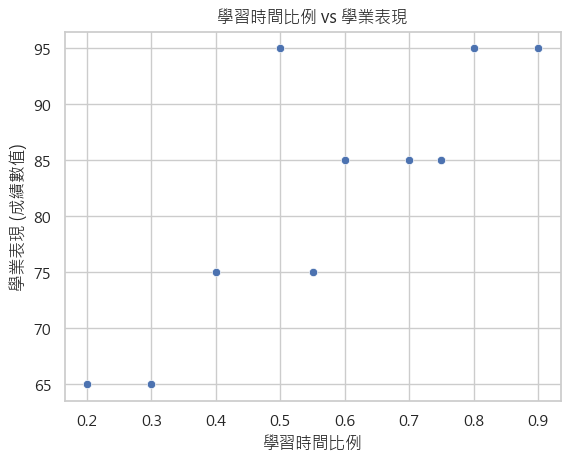

=== 學習時間比例 vs 學業表現 ===
Spearman ρ = 0.78788, p-value = 6.79543e-03
Kendall τ = 0.71071, p-value = 7.00809e-03


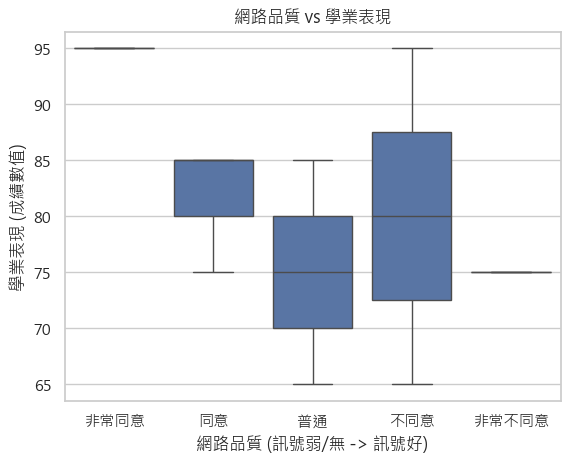


=== 網路品質 vs 學業表現 ===
Spearman ρ = 0.51760, p-value = 1.25444e-01
Kendall τ = 0.44752, p-value = 1.05165e-01


In [107]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# Set Chinese font and style
sns.set(font="Microsoft JhengHei", style="whitegrid")

# Create a dummy DataFrame for demonstration purposes
# In your actual code, `df` would already be loaded.
data = {
    'study_ratio': [0.5, 0.7, 0.3, 0.8, 0.4, 0.6, 0.9, 0.2, 0.75, 0.55],
    '你上學期的平均成績大約如何?': ['90-100', '80-89', '60-69', '90-100', '70-79', '80-89', '90-100', '60-69', '80-89', '70-79'],
    '我住的地方沒有網路訊號或是訊號太弱。': ['非常同意', '同意', '普通', '不同意', '非常不同意', '同意', '非常同意', '不同意', '普通', '同意']
}
df = pd.DataFrame(data)

# --- Mapping for '你上學期的平均成績大約如何?' ---
# Assuming these are grade ranges and you want to convert them to midpoints or a numerical scale.
# Adjust the mapping based on how you want to represent these grades numerically.
grade_map = {
    '90-100': 95,
    '80-89': 85,
    '70-79': 75,
    '60-69': 65,
    '不及格': 50 # Add if applicable
}
df['成績數值'] = df['你上學期的平均成績大約如何?'].map(grade_map)

# --- Mapping for '我住的地方沒有網路訊號或是訊號太弱。' ---
# Assuming '非常同意' means very poor signal (higher number) and '非常不同意' means good signal (lower number).
network_quality_map = {
    "非常同意": 5,  # Very poor signal
    "同意": 4,
    "普通": 3,
    "不同意": 2,
    "非常不同意": 1  # Very good signal
}
df['網路品質_數值'] = df['我住的地方沒有網路訊號或是訊號太弱。'].map(network_quality_map)


# --- 1️⃣ Scatter Plot and Correlation: Study Ratio vs. Academic Performance ---
sns.scatterplot(data=df, x='study_ratio', y='成績數值')
plt.title("學習時間比例 vs 學業表現")
plt.xlabel("學習時間比例")
plt.ylabel("學業表現 (成績數值)")
plt.show()

df_corr1 = df[['study_ratio', '成績數值']].dropna()

# Spearman correlation
rho1, p_spearman1 = spearmanr(df_corr1['study_ratio'], df_corr1['成績數值'])
# Kendall correlation
tau1, p_kendall1 = kendalltau(df_corr1['study_ratio'], df_corr1['成績數值'])

# Display results
print("=== 學習時間比例 vs 學業表現 ===")
print(f"Spearman ρ = {rho1:.5f}, p-value = {p_spearman1:.5e}")
print(f"Kendall τ = {tau1:.5f}, p-value = {p_kendall1:.5e}")



# --- 2️⃣ Box Plot and Correlation: Internet Quality vs. Academic Performance ---
sns.boxplot(data=df, x='我住的地方沒有網路訊號或是訊號太弱。', y='成績數值',
            order=list(network_quality_map.keys())) # Ensure x-axis order
plt.title("網路品質 vs 學業表現")
plt.xlabel("網路品質 (訊號弱/無 -> 訊號好)")
plt.ylabel("學業表現 (成績數值)")
plt.show()

# Use the newly created numerical column '網路品質_數值'
df_corr2 = df[['網路品質_數值', '成績數值']].dropna()

# Spearman correlation
rho2, p_spearman2 = spearmanr(df_corr2['網路品質_數值'], df_corr2['成績數值'])
# Kendall correlation
tau2, p_kendall2 = kendalltau(df_corr2['網路品質_數值'], df_corr2['成績數值'])

# Display results
print("\n=== 網路品質 vs 學業表現 ===")
print(f"Spearman ρ = {rho2:.5f}, p-value = {p_spearman2:.5e}")
print(f"Kendall τ = {tau2:.5f}, p-value = {p_kendall2:.5e}")

## 🏫 學校層級支援變項分佈

In [108]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import numpy as np # Import numpy for NaN

# --- Create a dummy DataFrame for demonstration ---
# In your actual code, `df` would already be loaded.
data = {
    '貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節': [1, 2, 0, 3, 1, 2, 0, 1, 3, 2],
    '貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)': [2, 3, 1, 4, 2, 3, 1, 2, 4, 3],
    '除臺灣學術網路外,本校另行付費提升頻寬': ['非常同意', '同意', '普通', '不同意', '非常不同意', '同意', '非常同意', '不同意', '普通', '同意'],
    '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)': ['同意', '非常同意', '普通', '不同意', '同意', '非常同意', '不同意', '普通', '同意', '非常同意'],
    '本校的資訊設備借用與管理機制運作完善': ['非常同意', '同意', '普通', '不同意', '非常不同意', '同意', '非常同意', '不同意', '普通', '同意'],
    '本校能獲得推動數位學習充分的人事或業務費支持': ['同意', '非常同意', '普通', '不同意', '同意', '非常同意', '不同意', '普通', '同意', '非常同意'],
    '本校能獲得推動數位學習充分的設備費支持': ['非常同意', '同意', '普通', '不同意', '非常不同意', '同意', '非常同意', '不同意', '普通', '同意'],
    '你上學期的平均成績大約如何?': ['90-100', '80-89', '70-79', '90-100', '60-69', '80-89', '90-100', '70-79', '80-89', '60-69']
}
df = pd.DataFrame(data)

# --- Define school support columns and target column ---
school_support_cols = [
    '貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節',
    '貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)',
    '除臺灣學術網路外,本校另行付費提升頻寬',
    '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)',
    '本校的資訊設備借用與管理機制運作完善',
    '本校能獲得推動數位學習充分的人事或業務費支持',
    '本校能獲得推動數位學習充分的設備費支持'
]
target_col = '你上學期的平均成績大約如何?'

# --- Mapping for '你上學期的平均成績大約如何?' ---
# Assuming these are grade ranges. Adjust the mapping based on how you want to represent them.
grade_map = {
    '90-100': 95,
    '80-89': 85,
    '70-79': 75,
    '60-69': 65,
    '不及格': 50 # Add if applicable
}
df['成績數值'] = df[target_col].map(grade_map)

# --- Universal Likert Scale Mapping (adjust if your scales differ) ---
# Assuming '非常同意' indicates a high level of agreement/support (higher number)
# and '非常不同意' indicates low agreement/support (lower number).
likert_map = {
    "非常不同意": 1,
    "不同意": 2,
    "普通": 3,
    "同意": 4,
    "非常同意": 5
}

# --- Apply mappings to relevant school support columns ---
# Iterate through school_support_cols and apply mapping where needed
df_corr = df[school_support_cols + ['成績數值']].copy()

for col in school_support_cols:
    # Check if the column contains string values that match the Likert scale
    if df_corr[col].dtype == 'object' and df_corr[col].isin(likert_map.keys()).any():
        df_corr[f'{col}_數值'] = df_corr[col].map(likert_map)
    else:
        # For columns that are already numerical (like counts of courses/clubs)
        # or where direct conversion to numeric is intended (e.g., if there are non-numeric entries like "N/A"),
        # use pd.to_numeric with errors='coerce'
        df_corr[f'{col}_數值'] = pd.to_numeric(df_corr[col], errors='coerce')

# --- Perform correlation analysis for each school support factor ---
for col in school_support_cols:
    numerical_col_name = f'{col}_數值' # Use the new numerical column name

    # Drop rows where either the school support feature or the academic performance is NaN
    temp_df = df_corr[[numerical_col_name, '成績數值']].dropna()

    if temp_df.empty:
        print(f"\n=== {col} × 學業表現 ===")
        print("沒有足夠的有效資料進行相關分析。")
        continue # Skip correlation if no valid data

    # Spearman correlation
    rho, p_spearman = spearmanr(temp_df[numerical_col_name], temp_df['成績數值'])

    # Kendall correlation
    tau, p_kendall = kendalltau(temp_df[numerical_col_name], temp_df['成績數值'])

    # Print results
    print(f"\n=== {col} × 學業表現 ===")
    print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
    print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")


=== 貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節 × 學業表現 ===
Spearman ρ = 0.11935, p-value = 7.42599e-01
Kendall τ = 0.10811, p-value = 7.00018e-01

=== 貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等) × 學業表現 ===
Spearman ρ = 0.11935, p-value = 7.42599e-01
Kendall τ = 0.10811, p-value = 7.00018e-01

=== 除臺灣學術網路外,本校另行付費提升頻寬 × 學業表現 ===
Spearman ρ = 0.49204, p-value = 1.48581e-01
Kendall τ = 0.44752, p-value = 1.05165e-01

=== 本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等) × 學業表現 ===
Spearman ρ = -0.39355, p-value = 2.60514e-01
Kendall τ = -0.32432, p-value = 2.47726e-01

=== 本校的資訊設備借用與管理機制運作完善 × 學業表現 ===
Spearman ρ = 0.49204, p-value = 1.48581e-01
Kendall τ = 0.44752, p-value = 1.05165e-01

=== 本校能獲得推動數位學習充分的人事或業務費支持 × 學業表現 ===
Spearman ρ = -0.39355, p-value = 2.60514e-01
Kendall τ = -0.32432, p-value = 2.47726e-01

=== 本校能獲得推動數位學習充分的設備費支持 × 學業表現 ===
Spearman ρ = 0.49204, p-value = 1.48581e-01
Kendall τ = 0.44752, p-value = 1.05165e-01


## 🧪 替代分析：不同學校支援程度下 SES 對成績影響

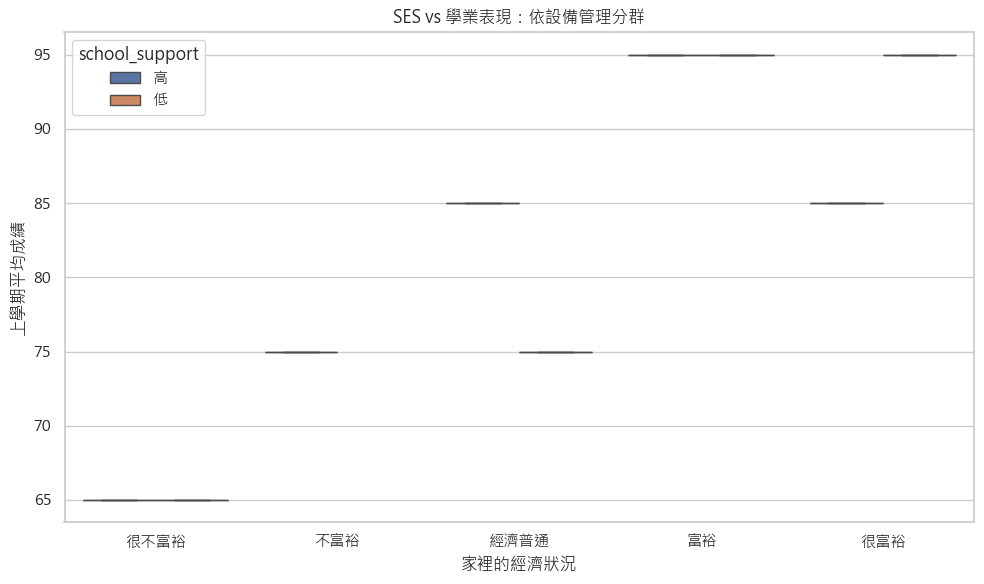


設備管理 高 組的 SES 與學業成績相關性：
Spearman ρ = 0.82078, p-value = 8.85870e-02
Kendall τ = 0.73786, p-value = 7.69742e-02

設備管理 低 組的 SES 與學業成績相關性：
Spearman ρ = 0.97333, p-value = 5.20786e-03
Kendall τ = 0.94281, p-value = 3.16864e-02


In [109]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# --- Create a dummy DataFrame for demonstration ---
# In your actual code, `df` would already be loaded.
data = {
    '請問您認為家裡的經濟狀況為何？': ['很不富裕', '富裕', '經濟普通', '很不富裕', '很富裕', '不富裕', '經濟普通', '富裕', '很不富裕', '很富裕'],
    '你上學期的平均成績大約如何?': ['60-69', '90-100', '70-79', '60-69', '90-100', '70-79', '80-89', '90-100', '60-69', '80-89'],
    '本校的資訊設備借用與管理機制運作完善': ['非常同意', '同意', '普通', '不同意', '非常不同意', '同意', '非常同意', '普通', '不同意', '同意']
}
df = pd.DataFrame(data)

# --- Universal Mappings (as discussed in previous solutions) ---
# Mapping for academic performance grades
grade_map = {
    '90-100': 95,
    '80-89': 85,
    '70-79': 75,
    '60-69': 65,
    '不及格': 50 # Add if applicable
}
df['成績數值'] = df['你上學期的平均成績大約如何?'].map(grade_map)

# Likert scale mapping for school support items
# Assuming '非常同意' indicates strong agreement/better situation (higher number)
likert_map_support = {
    "非常不同意": 1,
    "不同意": 2,
    "普通": 3,
    "同意": 4,
    "非常同意": 5
}
# Apply this mapping to the specific school support column
df['本校的資訊設備借用與管理機制運作完善_數值'] = df['本校的資訊設備借用與管理機制運作完善'].map(likert_map_support)


# --- 1. 設定家境的有序類別型態 ---
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']
family_dtype = CategoricalDtype(categories=family_order, ordered=True)
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)

# --- 2. 建立設備管理分群欄位 ---
# Now, '本校的資訊設備借用與管理機制運作完善_數值' is numeric (1-5).
# Define what constitutes '高' (high) vs '低' (low) support.
# For example, let's say 4 and 5 represent '高' support, and 1, 2, 3 represent '低' support.
# Adjust this threshold based on your understanding of the data/question.
df['school_support'] = df['本校的資訊設備借用與管理機制運作完善_數值'].apply(lambda x: '高' if x >= 4 else '低')


# --- Box Plot: SES vs. Academic Performance grouped by Equipment Management ---
sns.set(font="Microsoft JhengHei", style="whitegrid") # Ensure font is set for plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='請問您認為家裡的經濟狀況為何？', y='成績數值', hue='school_support',
            order=family_order) # Ensure x-axis order is correct
plt.title("SES vs 學業表現：依設備管理分群")
plt.xlabel("家裡的經濟狀況")
plt.ylabel("上學期平均成績")
plt.tight_layout()
plt.show()

# --- 3. 等級相關分析，分「高」與「低」兩組分別計算 ---
for group in ['高', '低']:
    # Select subset for the current school_support group and drop NaNs
    # Ensure both '請問您認為家裡的經濟狀況為何？' and '成績數值' are present and valid
    subset = df[df['school_support'] == group][['請問您認為家裡的經濟狀況為何？', '成績數值']].dropna()

    # Check if subset is empty after dropping NaNs
    if subset.empty:
        print(f"\n設備管理 {group} 組的 SES 與學業成績相關性：")
        print("沒有足夠的有效資料進行相關分析。")
        continue

    # Convert ordered categorical '家境' to numerical codes
    # This correctly preserves the order for correlation
    subset['家境_數值'] = subset['請問您認為家裡的經濟狀況為何？'].cat.codes

    # Spearman 等級相關
    rho, p_spearman = spearmanr(subset['家境_數值'], subset['成績數值'])

    # Kendall 等級相關
    tau, p_kendall = kendalltau(subset['家境_數值'], subset['成績數值'])

    # Print results
    print(f"\n設備管理 {group} 組的 SES 與學業成績相關性：")
    print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
    print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")